In [1]:
import os
os.environ['PYSR_AUTOLOAD_EXTENSIONS'] = 'no'
from matplotlib import pyplot as plt
from interpret import paretoize, overall_complexity, number_of_variables_in_expression
from utils import load_pickle
%matplotlib inline
SPLIT = 'test'
# SPLIT = 'random'
# SPLIT = 'val'

/home/sca63/.conda/envs/bnn_new_pysr/lib/python3.7/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  "torch was imported before juliacall. This may cause a segfault. "


In [2]:
version = 93102
# version = 11003
results_path = f'sr_results/{version}.pkl'
reg = load_pickle(results_path)
# results = reg.equations_[0]
results = reg.equations_

In [3]:
d = {2: {'version': 24880,
         'pysr_version': 93102},
     3: {'version': 74649,
         'pysr_version': 49636},
     4: {'version': 11566,
         'pysr_version': 94842},
     5: {'version': 72646,
         'pysr_version': 42503}}

f2_linear_models = {
    20: 8880,
    10: 22697,
    5: 13523,
    2: 22649,
    0: 4014,
}

# f2_linear_models = {
#     20: 2702,
#     10: 13529,
#     5: 7307,
#     2: 22160,
#     0: 4014,
# }

# d = {2: {'version': 24880,
#          'pysr_version': 11003},
#      3: {'version': 74649,
#          'pysr_version': 83278},
#      4: {'version': 11566,
#          'pysr_version': 51254},
#      5: {'version': 72646,
#          'pysr_version': 55894}}


In [4]:
def overall_complexity(entry, k: int):
    complexity = entry['complexity'].item()
    # return complexity
    num_variables = number_of_variables_in_expression(entry.equation)
    return complexity + (2*k - 1) * num_variables

In [5]:
k_results = {}
k_results2 = {}
for k, v in d.items():
    # load the original PySR table
    pysr_version = v['pysr_version']
    version = v['version']
    pysr_results = load_pickle(f'sr_results/{pysr_version}.pkl').equations_
    try:
        all_rmses = load_pickle(f'pickles/pysr_results_all_{version}_{pysr_version}.pkl')[SPLIT]
    except FileNotFoundError:
        print(f'File not found for {version} and {pysr_version}')
    except KeyError:
        print(f'Key not found for {version} and {pysr_version}')
        continue

    results = {}
    results2 = {}
    for comp in all_rmses.keys():
        eq = pysr_results[pysr_results['complexity'] == comp].iloc[0]
        overall_comp = overall_complexity(eq, k)
        results[overall_comp] = all_rmses[comp]
        results2[comp] = all_rmses[comp]

    k_results[k] = results
    k_results2[k] = results2

In [6]:
def nn_test_rmse(version):
    return load_pickle(f'pickles/nn_results_all_{version}.pkl')[SPLIT]

# calculate overall complexity
def overall_complexity_f2_linear(n_features):
    '''
    - each feature is mean/std of a k=2 input feature, which has complexity 2.
    - we do a linear combination of the features, so that is complexity 3 * n_features (2 for each feature, 1 for the product)
    - also we have a bias term, which adds 1
    '''
    return 3 * n_features + 1


f2_linear_results = {
    overall_complexity_f2_linear(k): nn_test_rmse(v) for k, v in f2_linear_models.items()
}

f1_id_results = load_pickle('pickles/pysr_results_all_28114_50620.pkl')[SPLIT]
# f1_id_results = load_pickle('pickles/pysr_results_all_28114_93890.pkl')[SPLIT]
# f1_id_results = load_pickle('pickles/pysr_results_all_28114_9054.pkl')[SPLIT]

pure_sr_results = load_pickle('pickles/pure_sr_results_all_83941.pkl')[SPLIT]
# get rid of entries with rmse over 2.0, because they were probably invalid equations
pure_sr_results = {k: v for k, v in pure_sr_results.items() if v < 2.0}

In [7]:
def plot_k(k_results):
    plt.rcParams["font.family"] = "serif"
    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    # plot k results
    for k in k_results:
        result = k_results[k]
        x, y = zip(*result.items())
        x, y = paretoize(x, y, replace=False)
        label = f'$k = {k}$' if k != 2 else '$k = 2$ (Ours)'
        ax.plot(x, y, marker='^', label=label)

    ax.set_xlabel('Overall complexity', fontsize=14, labelpad=10)
    ax.set_ylabel('RMSE (Resonant)', fontsize=14, labelpad=10)
    ax.legend()
    plt.tight_layout()
    plt.savefig('graphics/top_k_pareto.png', dpi=400, bbox_inches='tight')
    plt.show()


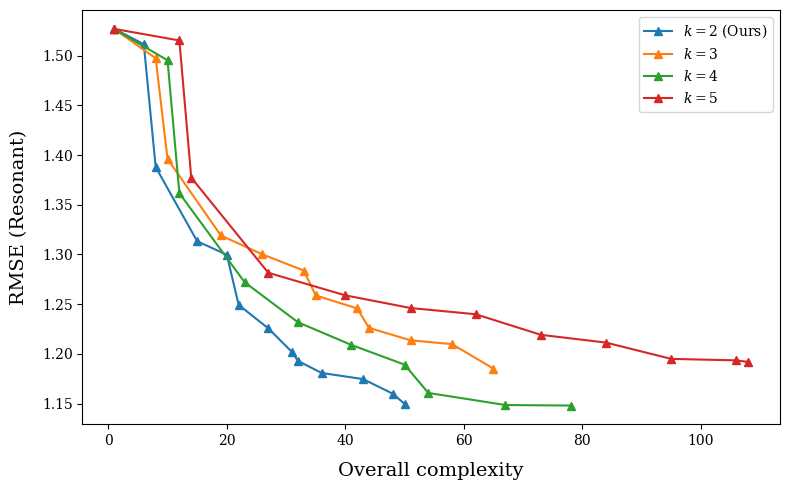

In [8]:
plot_k(k_results)

In [9]:
def plot_all():
    plt.rcParams["font.family"] = "serif"
    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    # # plot k results
    # for k in k_results:
    #     result = k_results[k]
    #     x, y = zip(*result.items())
    #     x, y = paretoize(x, y, replace=False)
    #     label = f'$k = {k}$' if k != 2 else '$k = 2$ (Ours)'
    #     ax.plot(x, y, marker='^', label=label)

    # plot k=2 results
    k = 2
    result = k_results[k]
    x, y = zip(*result.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker='^', label='Ours')

    # add f2 linear results
    x, y = zip(*f2_linear_results.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker='o', label='Linear $\psi$')

    # # add f1 id results
    # x, y = zip(*f1_id_results.items())
    # # x, y = paretoize(x, y, replace=False)
    # ax.plot(x, y, marker='o', label='Pure SR')

    # add pure SR results
    x, y = zip(*pure_sr_results.items())
    x, y = paretoize(x, y, replace=False)
    # ax.plot(x, y, marker='o', label='Pure SR w/ learned features')
    ax.plot(x, y, marker='o', label='Pure SR')

    ax.set_xlabel('Overall complexity', fontsize=14, labelpad=10)
    ax.set_ylabel('RMSE (Resonant)', fontsize=14, labelpad=10)
    ax.legend()
    plt.tight_layout()
    plt.savefig('graphics/comparison_pareto.png', dpi=400, bbox_inches='tight')
    plt.show()

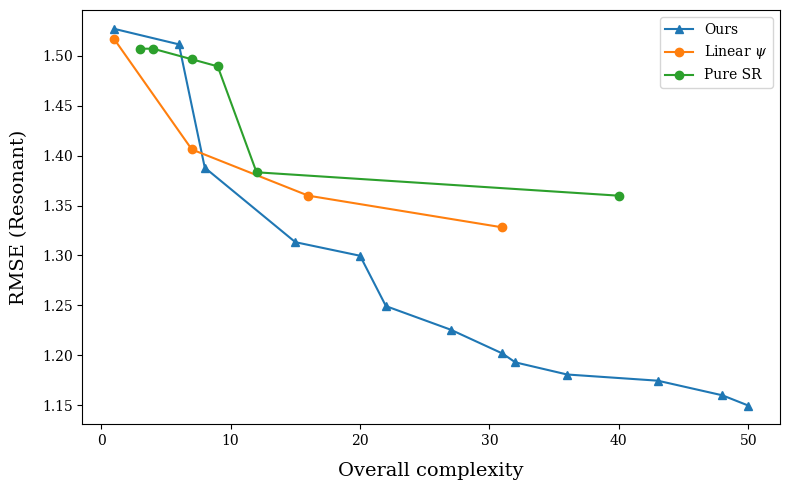

In [10]:
plot_all()